<a href="https://colab.research.google.com/github/abhisheksara2001/Twitter-User-GenderClassifier/blob/main/twitter_user_GenClassfier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
This data set was used to train a CrowdFlower AI gender predictor. The dataset can be found at https://www.kaggle.com/crowdflower/twitter-user-gender-classification. The dataset contains 20,000 rows, each with a user name, a random tweet, account profile and image, location, and even link and sidebar color.
<hr>
let's download the dataset zipfile from kaggle.

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# change permission
!chmod 600 ~/.kaggle/kaggle.json

# kaggle API command
!kaggle datasets download -d crowdflower/twitter-user-gender-classification

  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 48.3MB/s]


Extract the dataset file from zipfile.


In [3]:
from zipfile import ZipFile
file_name = 'twitter-user-gender-classification.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()

# Preprocessing Text
<hr>
import libraries

In [13]:
!pip install nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
import pandas as pd

In [15]:
def find_features(top_words, text):
    feature = {}
    for word in top_words:
        feature[word] = word in text.lower()
    return feature

In [16]:
base_url = '/content/gender-classifier-DFE-791531.csv'
df = pd.read_csv(base_url, encoding = 'latin1')
df.head(10)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,gender_gold,link_color,name,profile_yn_gold,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,NaN,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,NaN,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,louis whining and squealing and all,7696,NaN,ABB8C2,lwtprettylaugh,NaN,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,NaN,0084B4,douggarland,NaN,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,NaN,3B94D9,WilfordGemma,NaN,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN
5,815719231,False,finalized,3,10/27/15 1:47,female,1.0000,yes,1.0,3/11/10 18:14,you don't know me.,3901,NaN,F5ABB5,monroevicious,NaN,https://pbs.twimg.com/profile_images/656336865...,0,0,"Ive seen people on the train with lamps, chair...",NaN,20036,10/26/15 12:40,6.587300e+17,New York Gritty,Central Time (US & Canada)
6,815719232,False,finalized,3,10/27/15 1:57,brand,1.0000,yes,1.0,4/24/08 13:03,"A global marketplace for images, videos and mu...",4122,NaN,298AAE,Shutterstock,NaN,https://pbs.twimg.com/profile_images/528547133...,0,0,@BpackEngineer Thank you for your patience whi...,NaN,13354,10/26/15 12:40,6.587300e+17,Worldwide,Eastern Time (US & Canada)
7,815719233,False,finalized,3,10/26/15 23:48,male,1.0000,yes,1.0,12/3/12 21:54,The secret of getting ahead is getting started.,80,NaN,0000FF,RobinMeske,NaN,https://pbs.twimg.com/profile_images/508875440...,0,C0DEED,Gala Bingo clubs bought for å£241m: The UK's l...,NaN,112117,10/26/15 12:40,6.587300e+17,NaN,NaN
8,815719234,False,finalized,3,10/27/15 1:52,female,1.0000,yes,1.0,9/8/15 4:50,Pll Fan // Crazy about MCD // Ramen is bae,1825,NaN,9266CC,pigzilla_,NaN,https://pbs.twimg.com/profile_images/658670112...,0,0,@_Aphmau_ the pic defines all mcd fangirls/fan...,NaN,482,10/26/15 12:40,6.587300e+17,NaN,NaN
9,815719235,False,finalized,3,10/27/15 1:49,female,1.0000,yes,1.0,5/13/11 3:32,"Renaissance art historian, University of Notti...",3115,NaN,9266CC,GabrieleNeher,NaN,https://pbs.twimg.com/profile_images/513327289...,0,FFFFFF,@Evielady just how lovely is the tree this yea...,NaN,26085,10/26/15 12:40,6.587300e+17,"Nottingham, England.",Amsterdam


The dataset have many features but we are only using some features like description and text for predicting gender as target, the model will work with description and text features only.

In [17]:
all_descriptions = df['description']
all_tweets = df['text']
all_genders = df['gender']
all_gender_confidence = df['gender:confidence']
description_tweet_gender = []

we are using gender:confidence feature as a threshold if gender:confidence is more than 0.8 than only we will take the row or tweet for training the model. We are also removing all the rows where essential infomation is missing for example gender, text or description.

In [18]:
# Creation of bag of words for the description
bag_of_words = []
c = 0  # index
stop = stopwords.words('english')
for tweet in all_tweets:
    description = all_descriptions[c]
    gender = all_genders[c]
    gender_confidence = all_gender_confidence[c]
    
    # remove the rows which have empty tweet and description, unknown or empty gender or gender:confidence < 80%
    if (str(tweet) == 'nan' and str(description) == 'nan') or str(gender) == 'nan' or str(gender) == 'unknown' or float(gender_confidence) < 0.8:
        c+=1
        continue
    
    if str(tweet) == 'nan':
        tweet = ''
    if str(description) == 'nan':
        description = ''

      
    # removal of punctuations
    for punct in string.punctuation:
        if punct in tweet:
            tweet = tweet.replace(punct, " ")
        if punct in description:
            description = description.replace(punct, " ")
            
    # adding the word to the bag without stopwords 
    for word in tweet.split():
        if word.isalpha() and word.lower() not in stop:
            bag_of_words.append(word.lower())
    for word in description.split():
        if word.isalpha() and word.lower() not in stop:
            bag_of_words.append(word.lower())
    
    # using tweet and description for classification
    description_tweet_gender.append((tweet+" "+description , gender))
    c += 1

print(len(bag_of_words))
print(len(description_tweet_gender))

234145
13817


In [19]:
# get top 4000 words which will act as our features of each sentence
bag_of_words = nltk.FreqDist(bag_of_words)
top_words = []
for word in bag_of_words.most_common(4000):
    top_words.append(word[0])

top_words[:10]

['co', 'https', 'get', 'love', 'weather', 'like', 'http', 'one', 'life', 'new']

In [20]:
# creating the feature set, training set and the testing set
feature_set = [(find_features(top_words, text), gender) for (text, gender) in description_tweet_gender]
training_set = feature_set[:int(len(feature_set)*4/5)]
testing_set = feature_set[int(len(feature_set)*4/5):]

print("Length of feature set", len(feature_set))
print("Length of training set", len(training_set))
print("Length of testing set", len(testing_set))

Length of feature set 13817
Length of training set 11053
Length of testing set 2764


# Multinomial Naive Bayes Classifier
Naive Bayes algorithm works good with the text or words. we are using Multinomial Naive Bayes Classifier for gender classification on basis of tweet.

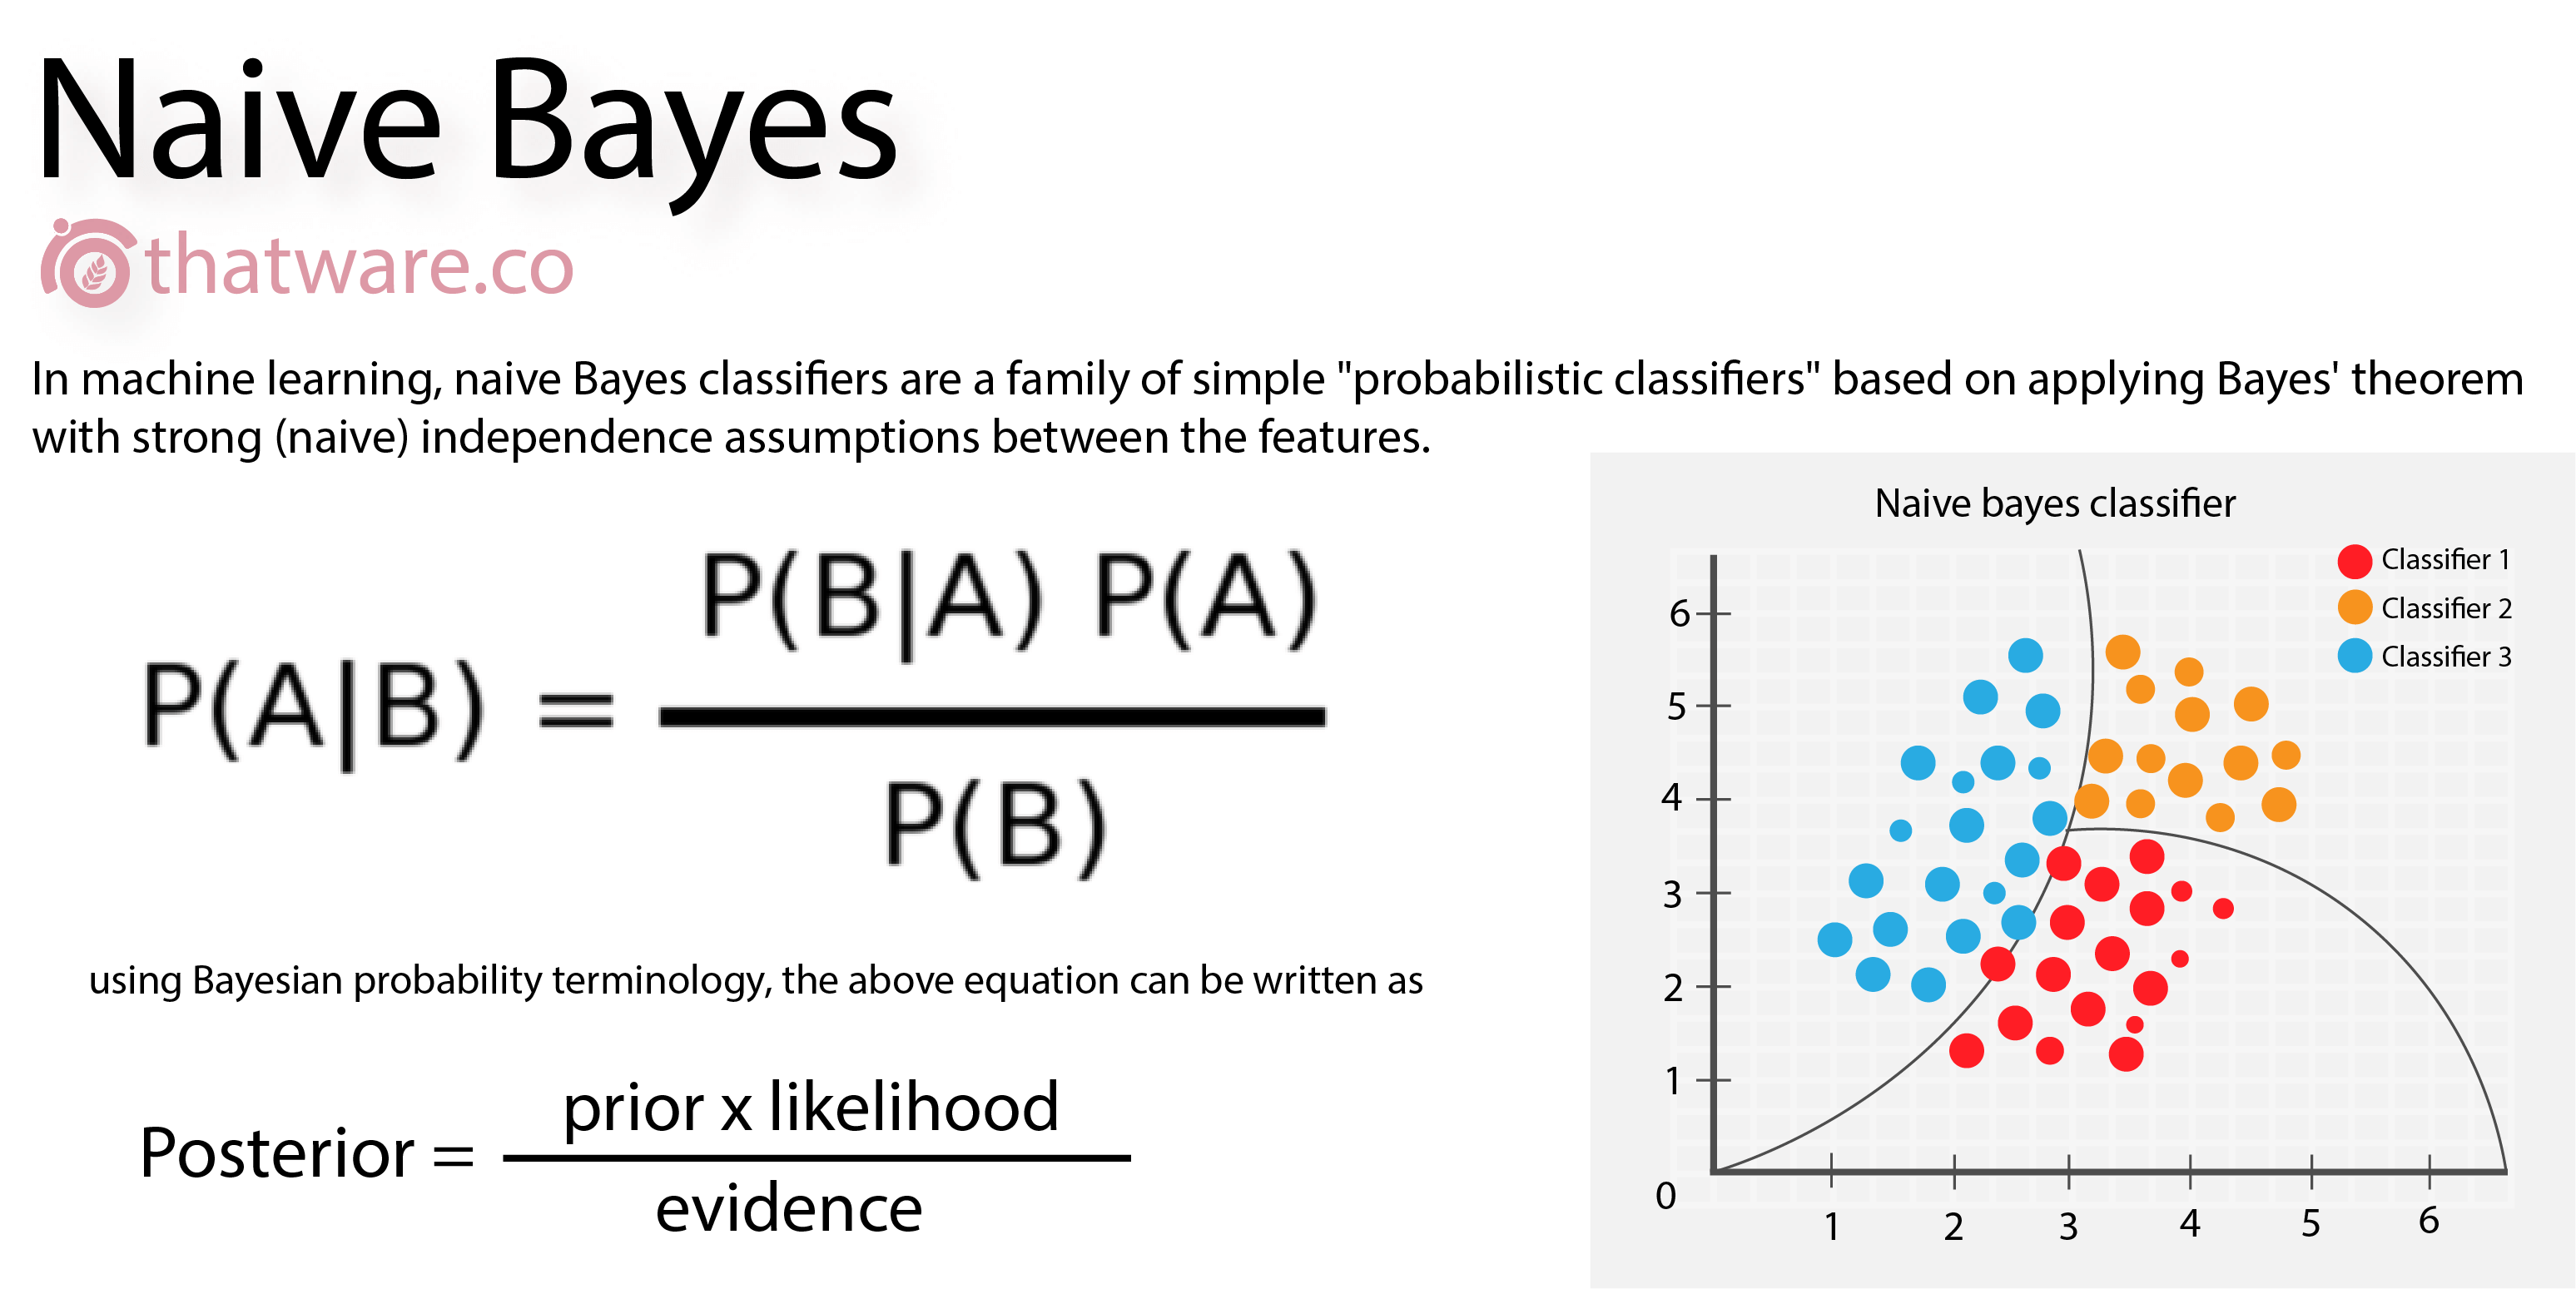

In [21]:
# creating a multinomial naive bayes classifier
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
accuracy = nltk.classify.accuracy(MNB_classifier, testing_set)*100
print("Multinomial Naive Bayes Classifier accuracy =", (accuracy))

Multinomial Naive Bayes Classifier accuracy = 64.6888567293777


#predict

In [28]:
description = "A global marketplace for images, videos and music. Sharing photos, inspiration, design tips & videos..."
text = "@BpackEngineer Thank you for your patience while we take care of the issue!"
features = find_features(top_words, description+" "+text)
print(MNB_classifier.classify(features))

brand
